# Лабораторная работа №1
# Анализ данных на основе регрессионых моделей
Работу выполнили студенты группы 4332: Лютов А.А., Будковой И.П.
## Задание:
Дан многомерный размеченный набор данных. Необходимо выполнить анализ
данных на основе регрессионных моделей в соответствии со следующей
последовательностью этапов.
1. Загрузить необходимые пакеты и библиотеки.
2. Загрузить данные из указанного источника.
3. Выполнить разведочный анализ данных в соответствии с этапами описанными
в файле Этапы проекта машинного обучения в примерах 1/2.pdf:
a. Ознакомление с данными с помощью методов описательной статистики.
b. Выполнить визуализацию данных одномерную для понимания
распределения данных и многомерную для выяснения зависимостей
между признаками.
c. При необходимости выполнить очистку данных одним из методов.
d. При необходимости преобразовать текстовые или категориальные
признаки одним из методов.
e. Проанализировать корреляционную зависимость между признаками.
f. Поэкспериментировать с комбинациями атрибутов. При необходимости
добавить новые атрибуты в набор данных.
g. Выполнить отбор существенных признаков. Сформировать набор
данных из существенных признаков и добавленных пользовательских
признаков.
h. Выполнить масштабирование данных для обоих наборов (исходного и
сформированного) одним из методов по варианту.
4. Анализ выполняется для исходного набора данных (проведена при
необходимости очистка данных и преобразованы текстовые или
категориальные признаки одним из рассмотренных методов),
масштабированного (п.3.h) исходного набора данных, построенного набора
данных (удаление неинформативных, добавление пользовательских
признаков) и масштабированного построенного набора данных. Во всех
наборах данных выделить обучающую и тестовую выборки данных.
5. Сравнить линейную (по варианту) и полиномиальную регрессионные модели на
обучающих и тестовой выборках для всех наборов данных, включая их
масштабированные варианты. Для оценки качества моделей использовать
метрики: корень из среднеквадратичной ошибки, R2.
6. Сделать выводы по проведенному анализу.
## Вариант: 3
Набор данных прибыли стартапов в зависимости от трех типов расходов.
Построить регрессионную модель для целевого признака «Profit» (прибыль
стартапа) от остальных входных признаков.
a. Пункт 3.h – Нормализация
b. Пункт 4 – гребневая регрессия (регуляризованная линейная регрессия)
## Ход работы

### Загрузка библиотек и пакетов

In [51]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import set_option
from pandas.plotting import scatter_matrix
from pickle import dump
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

### Загрузка данных
Удалим столбец Unnamed, если он есть в выборке

In [52]:
STARTUP_PATH = "v3.csv"
def load_startup_data(startup_path = STARTUP_PATH):
    return pd.read_csv(startup_path)
startup = load_startup_data()
if "Unnamed: 0" in startup.columns:
    startup = startup.drop("Unnamed: 0", axis=1)


### Разведочный анализ

#### Ознакомление с данными при помощи методов описательной статистики
Посмотрим, какие есть столбцы

In [53]:
startup.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,NaN,407934.54,Florida,191050.39
3,144372.41,NaN,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


Узнаем типы данных выборки и ее размер

In [54]:
startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   27 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


Заметим, что больше половины значений поля "Administration" не заполнены, поэтому рационально удалить этот столбец

In [55]:
startup.drop(["Administration"], axis=1, inplace=True)

Посмотрим, какие существуют категории

In [56]:
startup["State"].value_counts()

State
New York      17
California    17
Florida       16
Name: count, dtype: int64

Узнаем характеристики выборок

In [57]:
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
startup.describe()

,R&D Spend,Marketing Spend,Profit
count,50.00,50.00,50.00
mean,73721.62,211025.10,112012.64
std,45902.26,122290.31,40306.18
min,0.00,0.00,14681.40
25%,39936.37,129300.13,90138.90
50%,73051.08,212716.24,107978.19
75%,101602.80,299469.08,139765.98
max,165349.20,471784.10,192261.83


#### Одномерная визуализация данных

Построим гистограммы для численных признаков

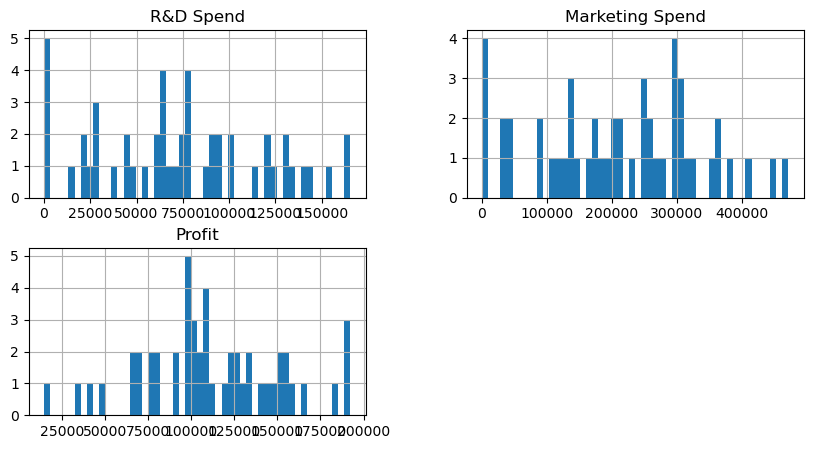

In [58]:
RnD_spend = startup["R&D Spend"]
marketing = startup["Marketing Spend"]
Profit = startup.Profit
substartup = pd.DataFrame({"R&D Spend": RnD_spend,
                             "Marketing Spend":marketing,
                           "Profit": Profit})
substartup.hist(bins=50, figsize=(10,5))
plt.show()

Построим графики плотности

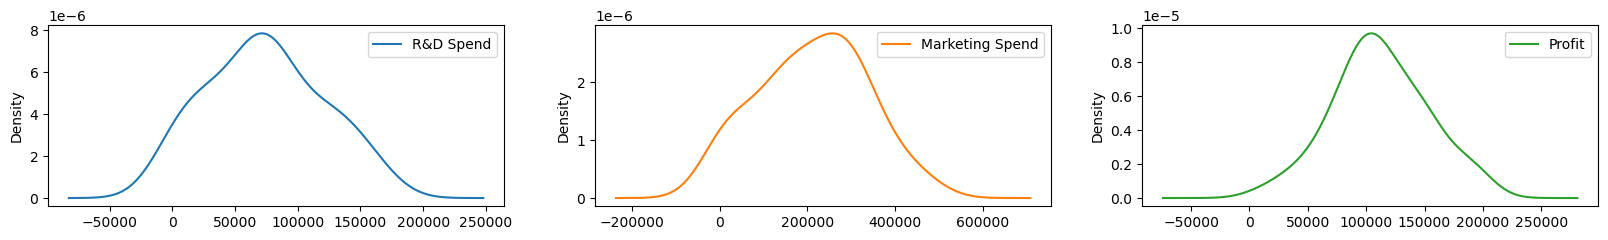

In [59]:
substartup.plot(kind='density', subplots=True, layout=(3,3),sharex=False, legend=True, figsize=(20,8))
plt.show()

#### Многомерная визуализация данных
Построим матрицу корреляция

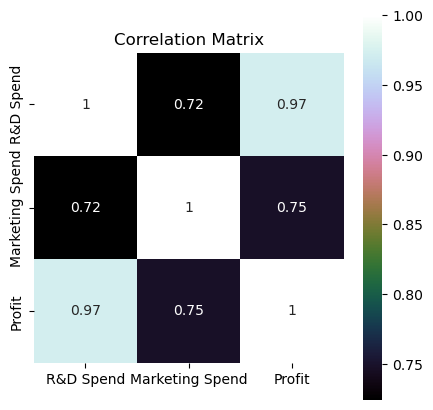

In [60]:
correlation = substartup.corr()
plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

Построим диаграмму рассеяния

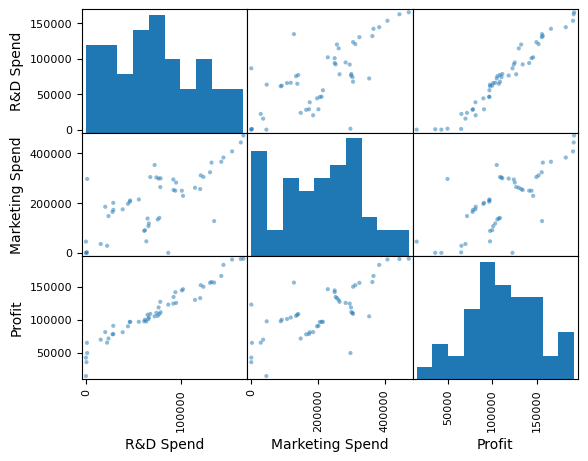

In [61]:
from pandas.plotting import scatter_matrix
scatter_matrix(startup)
plt.show()

#### Преобразование категориальных признаков
Преобразуем категориальный признак в отдельные бинарные признаки для каждой категории

In [62]:
startup_encoded = pd.get_dummies(startup, columns=['State'], drop_first=True)

#### Поиск корреляционной зависимости
Выполним корреляционный анализ

In [63]:
corr_matrix = startup_encoded.corr()
corr_matrix

,R&D Spend,Marketing Spend,Profit,State_Florida,State_New York
R&D Spend,1.00,0.72,0.97,0.11,0.04
Marketing Spend,0.72,1.00,0.75,0.21,-0.03
Profit,0.97,0.75,1.00,0.12,0.03
State_Florida,0.11,0.21,0.12,1.00,-0.49
State_New York,0.04,-0.03,0.03,-0.49,1.00


In [64]:
corr_matrix["Profit"].sort_values(ascending=False)

Profit            1.00
R&D Spend         0.97
Marketing Spend   0.75
State_Florida     0.12
State_New York    0.03
Name: Profit, dtype: float64

#### Создание новых признаков
Создадим больше признаков для корреляционного анализа

In [65]:
startup_encoded["Total Spend"] = (
    startup_encoded["R&D Spend"] +
    startup_encoded["Marketing Spend"]
)
startup_encoded["RnD_Ratio"] = startup_encoded["R&D Spend"] / startup_encoded["Total Spend"]
startup_encoded["Marketing_Ratio"] = startup_encoded["Marketing Spend"] / startup_encoded["Total Spend"]
startup_encoded["RnD_vs_Marketing"] = startup_encoded["R&D Spend"] - startup_encoded["Marketing Spend"]
startup_encoded["Average_Spend"] = startup_encoded["Total Spend"] / 3
startup_encoded["RnD_x_Marketing"] = startup_encoded["R&D Spend"] * startup_encoded["Marketing Spend"]
startup_encoded["High_RnD"] = (startup_encoded["R&D Spend"] > 100000).astype(int)

corr_matrix = startup_encoded.corr()

In [66]:

corr_matrix["Profit"].sort_values(ascending=False)

Profit              1.00
R&D Spend           0.97
RnD_x_Marketing     0.88
Total Spend         0.86
Average_Spend       0.86
High_RnD            0.76
Marketing Spend     0.75
State_Florida       0.12
RnD_Ratio           0.04
State_New York      0.03
Marketing_Ratio    -0.04
RnD_vs_Marketing   -0.50
Name: Profit, dtype: float64

Заметим, что такие признаки как штат, отношение затрат на RnD и Маркетинг, а также разница трат на Rnd и Маркетинг имеют низкую корреляцию

### Подготовка данных

#### Очистка данных
Очистим признаки, которые имеют низкую корреляцию

In [67]:
startup_encoded.drop(
    [ "RnD_vs_Marketing","State_New York", "State_Florida", "Marketing_Ratio", "RnD_Ratio"],
    axis=1,
    inplace=True
)


In [68]:
corr_matrix = startup_encoded.corr()
corr_matrix["Profit"].sort_values(ascending=False)

Profit            1.00
R&D Spend         0.97
RnD_x_Marketing   0.88
Total Spend       0.86
Average_Spend     0.86
High_RnD          0.76
Marketing Spend   0.75
Name: Profit, dtype: float64

#### Отбор признаков

In [69]:
selected_columns = [
    "R&D Spend", "Marketing Spend", "RnD_x_Marketing",
    "Total Spend", "Average_Spend", "High_RnD"
]
startup_X = startup_encoded[selected_columns]
startup_Y = startup_encoded["Profit"]

selector = SelectKBest(score_func=f_regression, k=4)

startup_X = pd.DataFrame(
    selector.fit_transform(startup_X, startup_Y),
    columns=selector.get_feature_names_out(selected_columns)
)

#### Нормализация данных

In [70]:
normalizer = Normalizer(norm='l2')  # Используем L2-нормализацию
data_X_normalized = pd.DataFrame(normalizer.fit_transform(startup_X), 
                               columns=startup_X.columns)

### Разработка модели

Разделяем датасет на две части: тестовую и тренировочную

In [71]:
test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(
    startup_X, startup_Y, test_size=test_size, random_state=seed
)

### Оценка моделей

Гребневая регрессия

In [72]:
model = Ridge(alpha=0.5)  
model.fit(X_train, y_train)  
Y_pred = model.predict(X_train)
rmse_ridge = np.sqrt(mean_squared_error(y_train, Y_pred))
r2_ridge = r2_score(y_train, Y_pred)
print("RMSE for Ridge Regression: ", rmse_ridge)
print("R2 score for Ridge Regression: ", r2_ridge)

RMSE for Ridge Regression:  8865.787116811707
R2 score for Ridge Regression:  0.9542826399907521


C:\Users\user\anaconda3\envs\MyEnv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.75824e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Полиномиальная регрессия


In [73]:
polynomial_feat = PolynomialFeatures(degree=2)
x_poly = polynomial_feat.fit_transform(X_train)  # Используем X_train
model = LinearRegression()
model.fit(x_poly, y_train)
Y_poly_pred = model.predict(x_poly)
rmse_poly = np.sqrt(mean_squared_error(y_train, Y_poly_pred))
r2_poly = r2_score(y_train, Y_poly_pred)
print("RMSE for Polynomial Regression: ", rmse_poly)
print("R2 score for Polynomial Regression: ", r2_poly)

RMSE for Polynomial Regression:  10096.03868158306
R2 score for Polynomial Regression:  0.940714490359492


### Выполним поиск гиперпараметров - степени полиномиальной регрессии

In [74]:
Deg = [1, 2, 3, 4, 6, 8, 10]
result_rmse = []
result_r2 = []

for deg in Deg:
    # Создаем полиномиальные признаки
    poly_feat = PolynomialFeatures(degree=deg)
    X_poly_train = poly_feat.fit_transform(X_train)  # Используем X_train вместо data_X_test
    
    # Обучаем модель
    model = LinearRegression()
    model.fit(X_poly_train, y_train)  # Используем y_train вместо data_X_test
    
    # Предсказания на тренировочных данных
    y_poly_pred = model.predict(X_poly_train)
    
    # Сохраняем метрики
    result_rmse.append(np.sqrt(mean_squared_error(y_train, y_poly_pred)))
    result_r2.append(r2_score(y_train, y_poly_pred))
print("Степени полиномов:", Deg)
print("RMSE для каждой степени:", [f"{x:.2f}" for x in result_rmse])
print("R2 для каждой степени:", [f"{x:.6f}" for x in result_r2])

Степени полиномов: [1, 2, 3, 4, 6, 8, 10]
RMSE для каждой степени: ['8865.79', '10096.04', '18371.98', '20440.26', '24035.44', '27243.66', '29318.79']
R2 для каждой степени: ['0.954283', '0.940714', '0.803683', '0.756993', '0.663991', '0.568304', '0.500036']


Выведем результаты

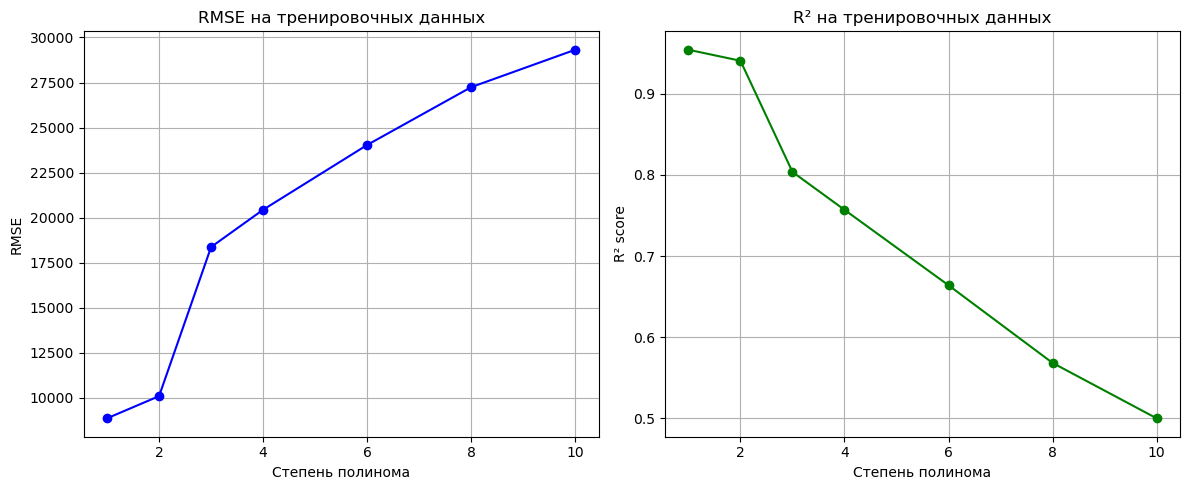

In [75]:
# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Deg, result_rmse, 'bo-')
plt.xlabel('Степень полинома')
plt.ylabel('RMSE')
plt.title('RMSE на тренировочных данных')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Deg, result_r2, 'go-')
plt.xlabel('Степень полинома')
plt.ylabel('R² score')
plt.title('R² на тренировочных данных')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Протестируем модель на тестовой выборке данных


In [76]:
poly_feat = PolynomialFeatures(degree=10)
X_poly_test = poly_feat.fit_transform(X_test)  
Y_test_pred = model.predict(X_poly_test)    # Используем обученную модель degree=10

rmse_poly = np.sqrt(mean_squared_error(y_test, Y_test_pred))  # y_test вместо data_X_test
r2_poly = r2_score(y_test, Y_test_pred)

print("\nПолиномиальная регрессия (degree=10) на тестовых данных:")
print("RMSE:", rmse_poly)
print("R2 score:", r2_poly)


Полиномиальная регрессия (degree=10) на тестовых данных:
RMSE: 220380.59760882362
R2 score: -47.21939165765691


Модель, полученная в результате, является очень неточной, что, скорее всего, связано с переобучением модели

Попробуем подобрать гиперпараметр методом кросс-валидации с использованием пайплайнов и с оценкой R2

In [77]:
Deg = [1, 2, 3, 4, 6, 8, 10]
result_r2 = []

for deg in Deg:
    model = Pipeline([
        ('polynomial', PolynomialFeatures(degree=deg)),
        ('regression', LinearRegression())
    ])
    # Исправленный вызов cross_val_score с правильными параметрами
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    result_r2.append(np.mean(scores))
print("\nРезультаты кросс-валидации:")
for deg, r2 in zip(Deg, result_r2):
    print(f"Degree {deg}: R2 = {r2:.6f}")


Результаты кросс-валидации:
Degree 1: R2 = 0.935638
Degree 2: R2 = 0.806651
Degree 3: R2 = -0.072041
Degree 4: R2 = -1.105226
Degree 6: R2 = -22.920506
Degree 8: R2 = -546.846811
Degree 10: R2 = -9275.449371


Отображение


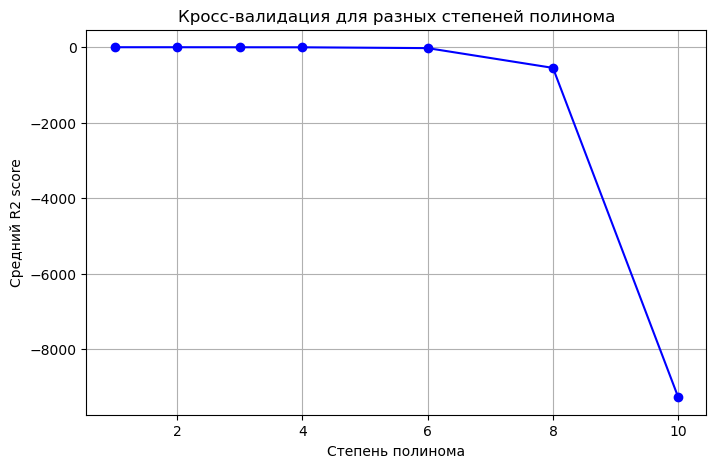

In [78]:
plt.figure(figsize=(8, 5))
plt.plot(Deg, result_r2, 'bo-')
plt.xlabel('Степень полинома')
plt.ylabel('Средний R2 score')
plt.title('Кросс-валидация для разных степеней полинома')
plt.grid(True)
plt.show()

Оптимальная степень полинома равна 1

### Финальная проверка на тестовой выборке

In [79]:
poly_feat = PolynomialFeatures(degree=1)  
X_poly_train = poly_feat.fit_transform(X_train)  

model = LinearRegression()
model.fit(X_poly_train, y_train)

Y_train_pred = model.predict(X_poly_train)
rmse_train = np.sqrt(mean_squared_error(y_train, Y_train_pred))
r2_train = r2_score(y_train, Y_train_pred)

print("\nОценка на обучающих данных:")
print(f"RMSE: {rmse_train:.2f}")
print(f"R2: {r2_train:.6f}")


Оценка на обучающих данных:
RMSE: 8865.79
R2: 0.954283


In [80]:
X_poly_test = poly_feat.transform(X_test)
Y_test_pred = model.predict(X_poly_test)

rmse_test = np.sqrt(mean_squared_error(y_test, Y_test_pred))
r2_test = r2_score(y_test, Y_test_pred)

print("\nОценка на тестовых данных:")
print(f"RMSE: {rmse_test:.2f}")
print(f"R2: {r2_test:.6f}")


Оценка на тестовых данных:
RMSE: 8934.56
R2: 0.920746


### Сохранение модели в файл

In [81]:
filename="final_model.sav"
dump(model,open(filename,"wb"))

## Вывод

В ходе работы была проведена полная предобработка и анализ набора данных о прибыли стартапов в зависимости от трёх видов расходов. Пропуски в столбце «Administration» привели к его удалению, категориальный признак «State» был закодирован dummy-переменными, после чего на основе корреляционного анализа и автоматического отбора признаков (SelectKBest) выделены четыре наиболее информативных фактора. Проведена L2-нормализация отобранных данных для обеспечения равного вклада признаков в модель. Сравнение гребневой регрессии и полиномиальных моделей показало, что сложные полиномиальные расширения приводят к серьёзному переобучению и ухудшению обобщающей способности, а оптимальной оказалась простая линейная регрессия (полиномиальная степень 1) с R² ≈ 0.92 и RMSE ≈ 8 900–9 100 на тестовых данных. Полученная модель демонстрирует высокую точность предсказания прибыли и сохранена для дальнейшего использования.